In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_profiling
import time

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
CATEGORICAL_COLUMNS = ["bldg_ctgy", "bldg_cls_s", "bldg_cls_p", "tax_cls_p", "tax_cls_s"]
LABEL_COLUMN = "label"
SECOND_TEST_COLUMNS = ["price", "bldg_cls_s", "borough", "lot", "tot_sqft"]
FIRST_TEST_COLUMNS = [*SECOND_TEST_COLUMNS, "long", "lat", "block", "lot", "yr_built", "tot_unit", "bldg_ctgy"]

In [3]:
data = pd.read_csv('ny_housing.csv')

In [4]:
data.drop(data.columns[0], axis=1, inplace=True)

In [5]:
data.rename(columns = {d:d[0:12] for d in data.columns[13:13+32]}, inplace=True)

In [6]:
data['price'].median()

580000.0

In [7]:
data['label'] = [1 if x > 500000 else 0 for x in data['price']]
data.drop('price', axis=1, inplace=True)

In [8]:
data[data['label'] == 1]

,borough,block,lot,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,...,tax_cls_p_1D,tax_cls_p_2,tax_cls_p_2A,tax_cls_p_2B,tax_cls_p_2C,tax_cls_p_4,tax_cls_s_1,tax_cls_s_2,tax_cls_s_4,label
3,2,2929,126,10457,2,0,2,3165,2394,1995,...,0,0,0,0,0,0,1,0,0,1
18,2,3050,28,10457,3,0,3,1250,2730,2003,...,0,0,0,0,0,0,1,0,0,1
19,2,3050,128,10457,3,0,3,1250,2730,2003,...,0,0,0,0,0,0,1,0,0,1
20,2,3050,129,10457,3,0,3,1739,2730,2003,...,0,0,0,0,0,0,1,0,0,1
23,2,3032,3,10458,8,0,8,3441,9240,1909,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27877,5,7020,373,10309,2,0,2,11044,2800,2001,...,0,0,0,0,0,0,1,0,0,1
27878,5,7022,25,10309,2,0,2,6174,3520,2011,...,0,0,0,0,0,0,1,0,0,1
27879,5,7022,27,10309,2,0,2,5400,3129,2012,...,0,0,0,0,0,0,1,0,0,1
27882,5,7267,91,10309,2,0,2,5645,1550,1997,...,0,0,0,0,0,0,1,0,0,1


In [9]:
features = {}
features[2] = list(data.drop(LABEL_COLUMN, axis=1).columns)
features[0] = [f for f in features[2] if f not in FIRST_TEST_COLUMNS]
features[1] = [f for f in features[2] if f not in SECOND_TEST_COLUMNS]

In [10]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
        
        records.append([self.times[-1][1], logs['accuracy']])

In [11]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32, label='target'):
  dataframe = dataframe.copy()
  labels = dataframe.pop(label)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [12]:
pd.set_option("display.max_columns", None)
data

,borough,block,lot,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,long,lat,bldg_ctgy_01,bldg_ctgy_02,bldg_ctgy_03,bldg_ctgy_05,bldg_ctgy_06,bldg_ctgy_07,bldg_ctgy_08,bldg_ctgy_09,bldg_ctgy_10,bldg_ctgy_11,bldg_ctgy_13,bldg_ctgy_14,bldg_ctgy_17,bldg_ctgy_21,bldg_ctgy_22,bldg_ctgy_23,bldg_ctgy_25,bldg_ctgy_26,bldg_ctgy_27,bldg_ctgy_29,bldg_ctgy_30,bldg_ctgy_31,bldg_ctgy_32,bldg_ctgy_33,bldg_ctgy_34,bldg_ctgy_35,bldg_ctgy_36,bldg_ctgy_37,bldg_ctgy_38,bldg_ctgy_39,bldg_ctgy_40,bldg_ctgy_41,bldg_cls_s_A0,bldg_cls_s_A1,bldg_cls_s_A2,bldg_cls_s_A3,bldg_cls_s_A4,bldg_cls_s_A5,bldg_cls_s_A6,bldg_cls_s_A7,bldg_cls_s_A8,bldg_cls_s_A9,bldg_cls_s_B1,bldg_cls_s_B2,bldg_cls_s_B3,bldg_cls_s_B9,bldg_cls_s_C0,bldg_cls_s_C1,bldg_cls_s_C2,bldg_cls_s_C3,bldg_cls_s_C4,bldg_cls_s_C5,bldg_cls_s_C6,bldg_cls_s_C7,bldg_cls_s_C8,bldg_cls_s_C9,bldg_cls_s_D0,bldg_cls_s_D1,bldg_cls_s_D2,bldg_cls_s_D3,bldg_cls_s_D4,bldg_cls_s_D5,bldg_cls_s_D6,bldg_cls_s_D7,bldg_cls_s_D8,bldg_cls_s_D9,bldg_cls_s_E1,bldg_cls_s_E2,bldg_cls_s_E3,bldg_cls_s_E4,bldg_cls_s_E7,bldg_cls_s_E9,bldg_cls_s_F1,bldg_cls_s_F2,bldg_cls_s_F4,bldg_cls_s_F5,bldg_cls_s_F8,bldg_cls_s_F9,bldg_cls_s_G0,bldg_cls_s_G1,bldg_cls_s_G2,bldg_cls_s_G3,bldg_cls_s_G4,bldg_cls_s_G5,bldg_cls_s_G8,bldg_cls_s_G9,bldg_cls_s_GU,bldg_cls_s_GW,bldg_cls_s_H1,bldg_cls_s_H2,bldg_cls_s_H3,bldg_cls_s_H4,bldg_cls_s_H6,bldg_cls_s_H9,bldg_cls_s_HB,bldg_cls_s_HR,bldg_cls_s_HS,bldg_cls_s_I1,bldg_cls_s_I4,bldg_cls_s_I5,bldg_cls_s_I6,bldg_cls_s_I7,bldg_cls_s_I9,bldg_cls_s_J2,bldg_cls_s_J4,bldg_cls_s_J6,bldg_cls_s_J8,bldg_cls_s_K1,bldg_cls_s_K2,bldg_cls_s_K4,bldg_cls_s_K5,bldg_cls_s_K6,bldg_cls_s_K7,bldg_cls_s_K9,bldg_cls_s_L1,bldg_cls_s_L2,bldg_cls_s_L8,bldg_cls_s_L9,bldg_cls_s_M1,bldg_cls_s_M2,bldg_cls_s_M3,bldg_cls_s_M4,bldg_cls_s_M9,bldg_cls_s_N2,bldg_cls_s_N4,bldg_cls_s_N9,bldg_cls_s_O1,bldg_cls_s_O2,bldg_cls_s_O3,bldg_cls_s_O4,bldg_cls_s_O5,bldg_cls_s_O6,bldg_cls_s_O7,bldg_cls_s_O8,bldg_cls_s_O9,bldg_cls_s_P2,bldg_cls_s_P3,bldg_cls_s_P5,bldg_cls_s_P6,bldg_cls_s_P7,bldg_cls_s_P9,bldg_cls_s_Q8,bldg_cls_s_R4,bldg_cls_s_R9,bldg_cls_s_RR,bldg_cls_s_S0,bldg_cls_s_S1,bldg_cls_s_S2,bldg_cls_s_S3,bldg_cls_s_S4,bldg_cls_s_S5,bldg_cls_s_S9,bldg_cls_s_T9,bldg_cls_s_V0,bldg_cls_s_V1,bldg_cls_s_V9,bldg_cls_s_W1,bldg_cls_s_W2,bldg_cls_s_W3,bldg_cls_s_W6,bldg_cls_s_W7,bldg_cls_s_W8,bldg_cls_s_W9,bldg_cls_s_Y6,bldg_cls_s_Z9,bldg_cls_p_A0,bldg_cls_p_A1,bldg_cls_p_A2,bldg_cls_p_A3,bldg_cls_p_A4,bldg_cls_p_A5,bldg_cls_p_A6,bldg_cls_p_A7,bldg_cls_p_A8,bldg_cls_p_A9,bldg_cls_p_B1,bldg_cls_p_B2,bldg_cls_p_B3,bldg_cls_p_B9,bldg_cls_p_C0,bldg_cls_p_C1,bldg_cls_p_C2,bldg_cls_p_C3,bldg_cls_p_C4,bldg_cls_p_C5,bldg_cls_p_C6,bldg_cls_p_C7,bldg_cls_p_C8,bldg_cls_p_C9,bldg_cls_p_D0,bldg_cls_p_D1,bldg_cls_p_D2,bldg_cls_p_D3,bldg_cls_p_D4,bldg_cls_p_D5,bldg_cls_p_D6,bldg_cls_p_D7,bldg_cls_p_D8,bldg_cls_p_D9,bldg_cls_p_E1,bldg_cls_p_E3,bldg_cls_p_E4,bldg_cls_p_E7,bldg_cls_p_E9,bldg_cls_p_F1,bldg_cls_p_F2,bldg_cls_p_F4,bldg_cls_p_F5,bldg_cls_p_F8,bldg_cls_p_F9,bldg_cls_p_G0,bldg_cls_p_G1,bldg_cls_p_G2,bldg_cls_p_G3,bldg_cls_p_G4,bldg_cls_p_G5,bldg_cls_p_G8,bldg_cls_p_G9,bldg_cls_p_H1,bldg_cls_p_H2,bldg_cls_p_H3,bldg_cls_p_H4,bldg_cls_p_H6,bldg_cls_p_H9,bldg_cls_p_HB,bldg_cls_p_HR,bldg_cls_p_HS,bldg_cls_p_I1,bldg_cls_p_I4,bldg_cls_p_I5,bldg_cls_p_I6,bldg_cls_p_I7,bldg_cls_p_I9,bldg_cls_p_J2,bldg_cls_p_J4,bldg_cls_p_J6,bldg_cls_p_J8,bldg_cls_p_K1,bldg_cls_p_K2,bldg_cls_p_K4,bldg_cls_p_K5,bldg_cls_p_K6,bldg_cls_p_K7,bldg_cls_p_K9,bldg_cls_p_L1,bldg_cls_p_L2,bldg_cls_p_L3,bldg_cls_p_L8,bldg_cls_p_L9,bldg_cls_p_M1,bldg_cls_p_M2,bldg_cls_p_M3,bldg_cls_p_M4,bldg_cls_p_M9,bldg_cls_p_N2,bldg_cls_p_N4,bldg_cls_p_N9,bldg_cls_p_O1,bldg_cls_p_O2,bldg_cls_p_O3,bldg_cls_p_O4,bldg_cls_p_O5,bldg_cls_p_O6,bldg_cls_p_O7,bldg_cls_p_O8,bldg_cls_p_O9,bldg_cls_p_P2,bldg_cls_p_P3,bldg_cls_p_P5,bldg_cls_p_P6,bldg_cls_p_P7,bldg_cls_p_P9,bldg_cls_p_Q8,bldg_cls_p_R9,bldg_cls_p_RR,bldg_cls_p_S0,bldg_cls_p_S1,bldg_cls_p_S2,bldg_cls_p_S3,bldg_cls_p_S4,bldg_cls_p_S5,bldg_cls_p_

5577 train examples
22309 test examples
Train size:  0.2 Features version:  0
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


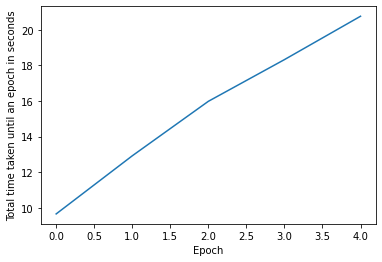

Consider rewriting this model with the Functional API.


698/698 [==============================] - 6s 9ms/step - loss: 0.7916 - accuracy: 0.4521
Train size:  0.2 Features version:  1
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


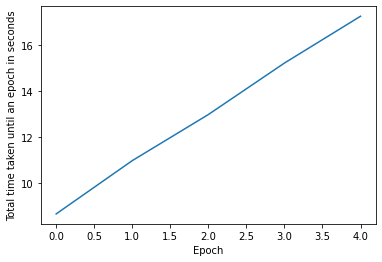

Consider rewriting this model with the Functional API.


698/698 [==============================] - 6s 8ms/step - loss: 0.7321 - accuracy: 0.4976
Train size:  0.2 Features version:  2
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


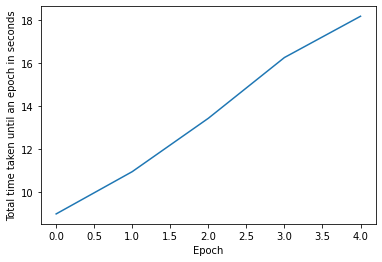

Consider rewriting this model with the Functional API.


698/698 [==============================] - 6s 8ms/step - loss: 1.0210 - accuracy: 0.5190
13943 train examples
13943 test examples
Train size:  0.5 Features version:  0
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


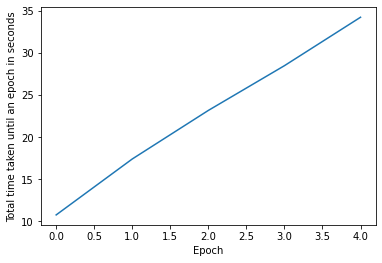

Consider rewriting this model with the Functional API.


436/436 [==============================] - 4s 8ms/step - loss: 0.7789 - accuracy: 0.4685
Train size:  0.5 Features version:  1
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


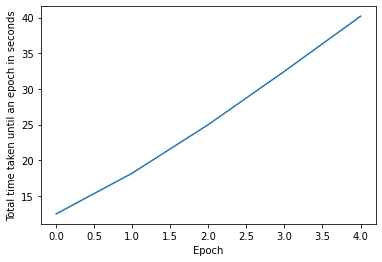

Consider rewriting this model with the Functional API.


436/436 [==============================] - 4s 10ms/step - loss: 0.6289 - accuracy: 0.6515 0s - loss: 0.6298 - accura
Train size:  0.5 Features version:  2
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


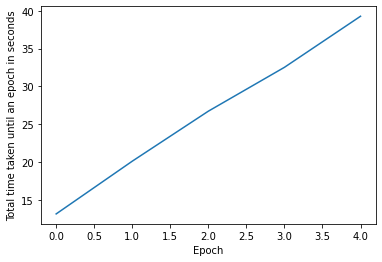

Consider rewriting this model with the Functional API.


436/436 [==============================] - 4s 9ms/step - loss: 0.5661 - accuracy: 0.7089
22308 train examples
5578 test examples
Train size:  0.8 Features version:  0
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


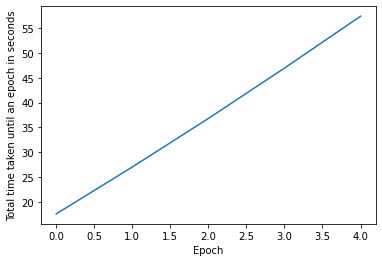

Consider rewriting this model with the Functional API.


175/175 [==============================] - 1s 8ms/step - loss: 0.6731 - accuracy: 0.4512
Train size:  0.8 Features version:  1
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


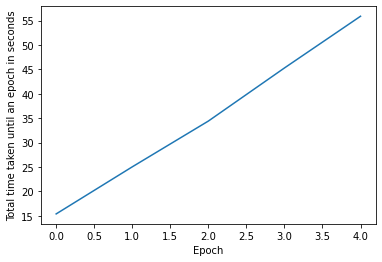

Consider rewriting this model with the Functional API.


175/175 [==============================] - 1s 7ms/step - loss: 0.5641 - accuracy: 0.7354
Train size:  0.8 Features version:  2
Consider rewriting this model with the Functional API.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.


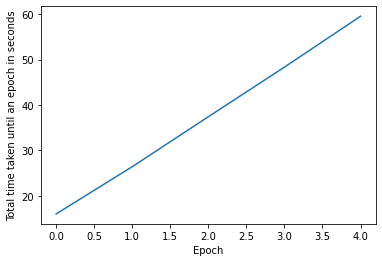

Consider rewriting this model with the Functional API.


175/175 [==============================] - 1s 8ms/step - loss: 0.5401 - accuracy: 0.6798


In [13]:
records = []

for train_size in [0.2, 0.5, 0.8]:

    train, test = train_test_split(data, test_size=1 - train_size)
    print(len(train), 'train examples')
    print(len(test), 'test examples')

    batch_size = 32
    train_ds = df_to_dataset(train, batch_size=batch_size, label='label')
    test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size, label='label')
    
    for features_version in [0, 1, 2]:
        
        print("Train size: ", train_size, "Features version: ", features_version)
        
        feature_columns = []

        numeric_cols = data[features[features_version]].select_dtypes(include=np.number).columns.tolist()

         # numeric cols
        for header in numeric_cols:
            feature_columns.append(feature_column.numeric_column(header))

        cat_cols = [h for h in data.columns if h not in numeric_cols]
        
        # embedding cols
        for header in cat_cols:
            if(header not in features[features_version]):
                continue
                
            col = feature_column.categorical_column_with_vocabulary_list(
                  header, data[header].unique())
            embedding = feature_column.embedding_column(col, dimension=8)
            feature_columns.append(embedding)

        feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
        
        model = tf.keras.Sequential([
          feature_layer,
          layers.Dense(64, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dropout(.1),
          layers.Dense(1)
        ])

        model.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        timetaken = timecallback()
        
        model.fit(train_ds, epochs=5, callbacks=[timetaken], verbose=0)

        _, test_accuracy = model.evaluate(test_ds)
        records[-1].append(test_accuracy)

In [19]:
results = []
i = 0
for train_size in [0.2, 0.5, 0.8]:
    for features_version in [0, 1, 2]:
        results.append({
            'split': train_size, 
            'features': features_version,
            'time': round(records[i][0], 3) ,
            'train_acc': round(records[i][1], 3),
            'test_acc': round(records[i][2], 3)
        })
        
        i = i+1

In [20]:
results_df = pd.DataFrame(results)
results_df

,split,features,time,train_acc,test_acc
0,0.2,0,20.766,0.443,0.452
1,0.2,1,17.234,0.586,0.498
2,0.2,2,18.172,0.486,0.519
3,0.5,0,34.234,0.447,0.468
4,0.5,1,40.188,0.475,0.652
5,0.5,2,39.281,0.642,0.709
6,0.8,0,57.391,0.464,0.451
7,0.8,1,55.891,0.665,0.735
8,0.8,2,59.516,0.704,0.680


In [21]:
results_df.to_csv('NN_ny_housing_result.csv')

In [22]:
print(results_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  split &  features &    time &  train\_acc &  test\_acc \\
\midrule
0 &    0.2 &         0 &  20.766 &      0.443 &     0.452 \\
1 &    0.2 &         1 &  17.234 &      0.586 &     0.498 \\
2 &    0.2 &         2 &  18.172 &      0.486 &     0.519 \\
3 &    0.5 &         0 &  34.234 &      0.447 &     0.468 \\
4 &    0.5 &         1 &  40.188 &      0.475 &     0.652 \\
5 &    0.5 &         2 &  39.281 &      0.642 &     0.709 \\
6 &    0.8 &         0 &  57.391 &      0.464 &     0.451 \\
7 &    0.8 &         1 &  55.891 &      0.665 &     0.735 \\
8 &    0.8 &         2 &  59.516 &      0.704 &     0.680 \\
\bottomrule
\end{tabular}

